# Graduate Project of CNN Regression version 2.0

## Initialize machine learning library

In [371]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print(torch.__version__)

2.6.0+cpu


### Set computing device as CPU

In [372]:
device = torch.device("cpu")
print(f"Using Device: {device}")

Using Device: cpu


## Data load in and pre-processing

In [373]:
features = pd.read_csv("/home/seb/Project/BEng-Graduate/data/data.csv", header=None)
features = features.transpose()
# features = data.values.T.astype(np.float32)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,500,501,502,503,504,505,506,507,508,509
0,70.0,200.0,300.0,28.801196,81.105366,6125.0,5690.0,6560.0,870.0,-120.782809,...,-118.949780,-118.499691,-118.020283,-117.503018,-116.936596,-116.305609,-115.588315,-114.752730,-113.749309,-112.495888
1,70.0,200.0,400.0,2.517709,47.612011,3860.0,3840.0,3880.0,40.0,-121.070769,...,-116.630247,-116.579676,-116.529680,-116.480227,-116.431285,-116.382825,-116.334820,-116.287244,-116.240073,-116.193283
2,70.0,200.0,500.0,3.068820,63.245190,3945.0,3920.0,3970.0,50.0,-121.322709,...,-113.516857,-113.319928,-113.096880,-112.840765,-112.541882,-112.186250,-111.752916,-111.208943,-110.499310,-109.524470
3,70.0,200.0,600.0,5.874144,55.115136,4050.0,4000.0,4100.0,100.0,-121.477196,...,-108.600004,-104.475919,-92.225585,-111.170745,-123.172305,-140.835187,-127.837068,-124.087345,-122.231465,-121.097501
4,70.0,200.0,700.0,-123.202804,67.654798,3635.0,4160.0,3110.0,-1050.0,-121.156614,...,-116.668022,-116.650467,-116.633328,-116.616634,-116.600387,-116.584503,-116.569146,-116.554043,-116.539304,-116.524892


Check data shape

In [374]:
print("data dimension:", features.shape)

data dimension: (392, 510)


### Draw original feature-describing histograms

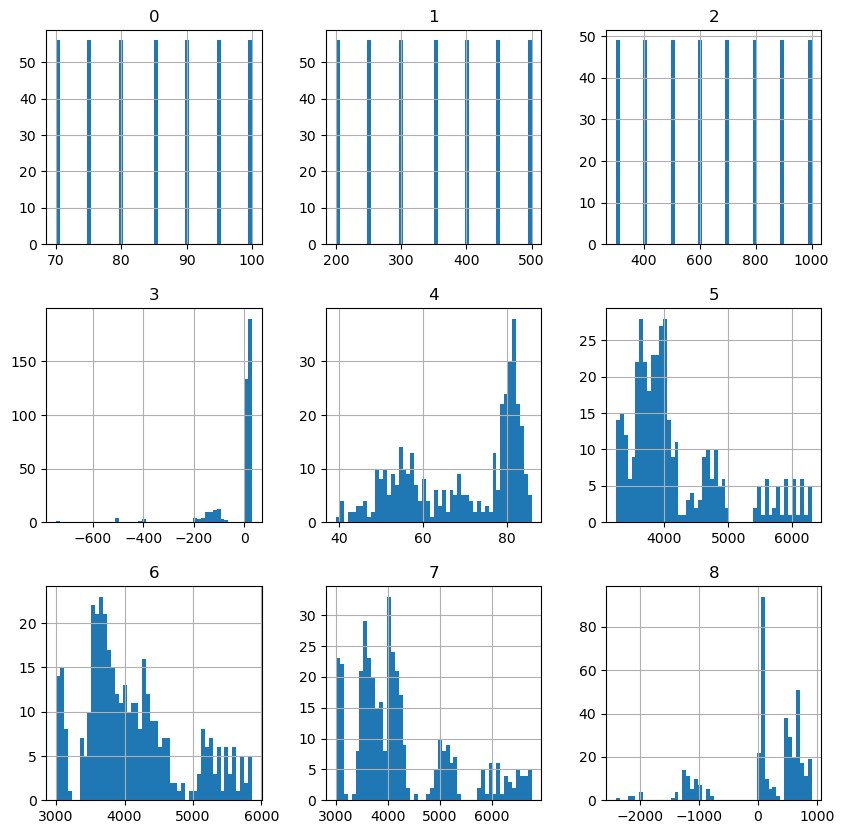

In [375]:
fea = features.iloc[:, :9]
fea.hist(bins=50, figsize=(10,10))
plt.show()

### Set label and transform it into a nparray

In [376]:
labels = np.array(features.iloc[:,9:])
features = np.array(features.iloc[:, :9])
features.shape

(392, 9)

## Exploratory Data Analysis

### Show the variation of respective features

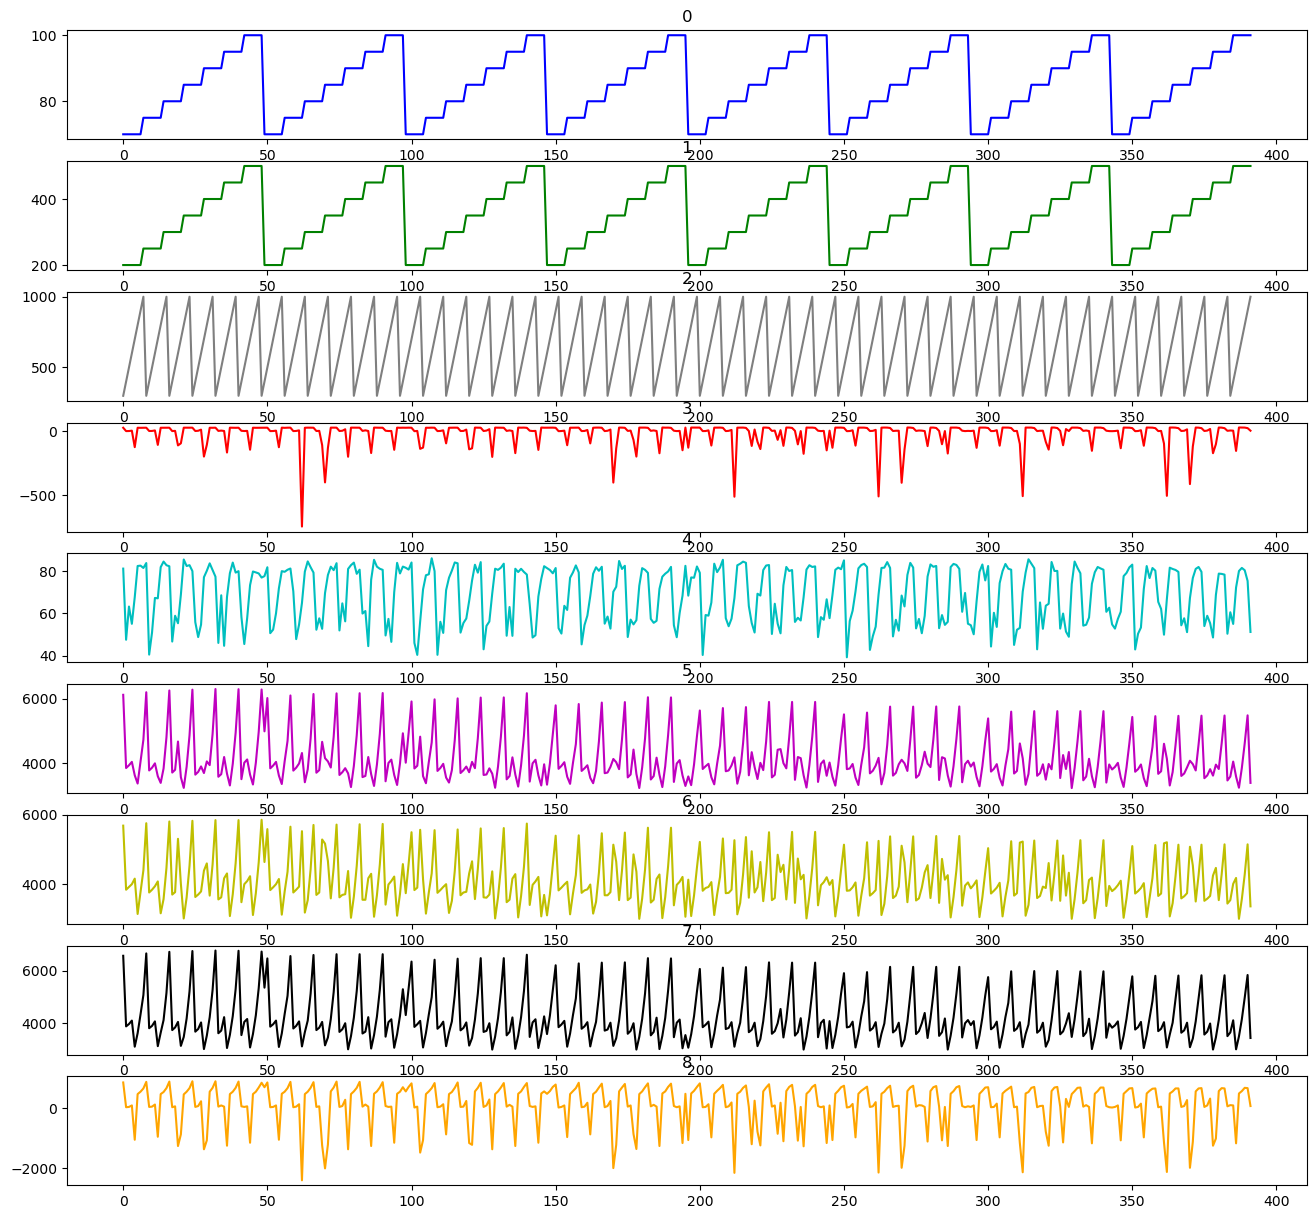

In [377]:
plt.figure(figsize=(16,15))
color = ['b', 'g', '#7f7f7f', 'r', 'c', 'm', 'y', 'k', '#FFA500']
for i in range(9):
  plt.subplot(9,1, i+1)
  a, = plt.plot(features[:,i],color= color[i])
  plt.title(i)

plt.show()

### Data standardization using sklearn

In [378]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
input_features = preprocessing.StandardScaler().fit_transform(features)
input_labels = preprocessing.StandardScaler().fit_transform(labels)
input_features[0]

array([-1.5       , -1.5       , -1.52752523,  0.47353794,  0.91441986,
        2.55646587,  2.22862805,  2.44093019,  1.07199055])

### Show histograms of standardized-features

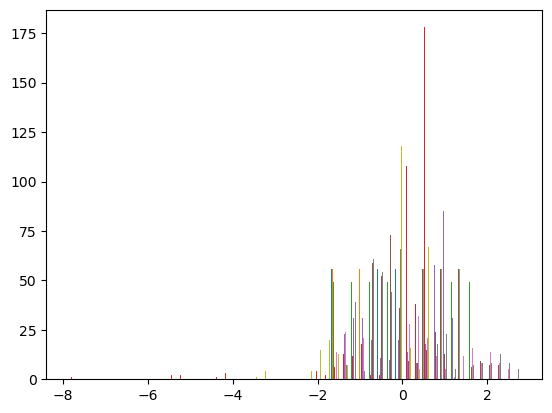

In [379]:
plt.hist(input_features, bins=50)
plt.show()

## Split data set into training and validating

In [380]:
x_train, x_val, y_train, y_val = train_test_split(input_features, input_labels, train_size = 0.8, shuffle = True, random_state = 2019)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 9, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32).reshape(-1, 9, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

check set tpye

In [381]:
print(type(x_train))
print(type(x_train_tensor))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


## Constract Convolutional Neural Network

### Import torch libraries

In [382]:
import torch
import torch.nn as nn
from torch.nn import Conv1d 
from torch.nn import MaxPool1d 
from torch.nn import Flatten 
from torch.nn import AvgPool1d
from torch.nn import BatchNorm1d
from torch.nn import Linear 
from torch.utils.data import DataLoader, TensorDataset 
import torch.optim as optim
import torch.nn.functional as F

### Define Hyper-parameters and set dataloader

In [383]:
input_size = 9
output_size = 501
num_epochs = 200
batch_size = 32

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Set up CNN module

In [384]:
class CNNRegressor(nn.Module):
    def __init__(self, inputs, outputs):
        super(CNNRegressor, self).__init__()
        self.inputs = inputs
        self.outputs = outputs

        # Convolution Sequence 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                inputs, 
                32, 
                kernel_size = 3, 
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 1)
        )

        # Convolution Sequence 2 with Batch Normalization and AP
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 64),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size = 1)
        )

        # Convolution Sequence 3 with 3 convolutional layers
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 128),
            nn.ReLU()
        )

        # Convolution Sequence 4 with flatten and FC layers
        self.conv4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.out = nn.Linear(64, outputs)

    # Forward function
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # print("Before Flatten: ", x.shape)
        x = self.conv4(x)
        # print("After Flatten: ", x.shape)
        x = self.out(x)
        return x

### Training CNN model

In [385]:
# Instantiation
model = CNNRegressor(input_size, output_size)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# optimizer = SGD(model.parameters(), lr = 1e-7)
# optimizer = Adagrad(model.parameters(), lr= 1e-5)
# optimizer = Adam(model.parameters(), lr = 1e-6 )
# optimizer = RMSprop(model.parameters(), lr = 1e-6 )

# Looping
for epoch in range(num_epochs):
    # Training mode
    model.train()  
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward
        optimizer.zero_grad()  # Empty grad
        loss.backward()        # Compute grad
        optimizer.step()        # Update parameters

        running_loss += loss.item() # Update loss

    # Computer loss
    avg_train_loss = running_loss / len(train_loader)

    # Computer Val loss
    model.eval()  # Evaluation mode
    val_loss = 0.0
    predictions_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            predictions_list.append(outputs.numpy())
            targets_list.append(targets.numpy())

    predictions = np.concatenate(predictions_list, axis=0)
    targets = np.concatenate(targets_list, axis=0)

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training Complete.")

Epoch [1/200], Train Loss: 1.0187, Val Loss: 0.9731
Epoch [2/200], Train Loss: 0.9804, Val Loss: 0.9713
Epoch [3/200], Train Loss: 0.9305, Val Loss: 0.9574
Epoch [4/200], Train Loss: 0.8746, Val Loss: 0.9048
Epoch [5/200], Train Loss: 0.8466, Val Loss: 0.8485
Epoch [6/200], Train Loss: 0.8153, Val Loss: 0.7693
Epoch [7/200], Train Loss: 0.7632, Val Loss: 0.7333
Epoch [8/200], Train Loss: 0.7259, Val Loss: 0.7137
Epoch [9/200], Train Loss: 0.7270, Val Loss: 0.6743
Epoch [10/200], Train Loss: 0.6728, Val Loss: 0.6728
Epoch [11/200], Train Loss: 0.6445, Val Loss: 0.6467
Epoch [12/200], Train Loss: 0.6365, Val Loss: 0.6592
Epoch [13/200], Train Loss: 0.6163, Val Loss: 0.6177
Epoch [14/200], Train Loss: 0.6009, Val Loss: 0.6094
Epoch [15/200], Train Loss: 0.5839, Val Loss: 0.5809
Epoch [16/200], Train Loss: 0.5718, Val Loss: 0.5875
Epoch [17/200], Train Loss: 0.5977, Val Loss: 0.5883
Epoch [18/200], Train Loss: 0.5750, Val Loss: 0.5703
Epoch [19/200], Train Loss: 0.5410, Val Loss: 0.5627
Ep

### Compare predictions to actural values

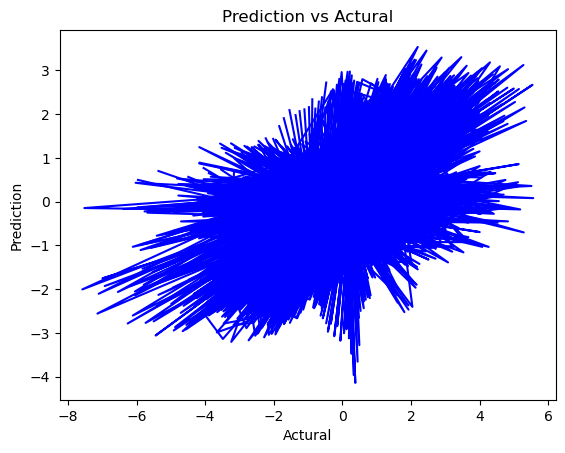

In [386]:
# Compare actural values with prediction
plt.plot(targets, predictions, 'b-')

# Set graph config
plt.xlabel('Actural'); plt.ylabel('Prediction'); plt.title('Prediction vs Actural')
plt.show()